In [188]:
import os
import wandb
import torch
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
import umap

# Load from W&B
api = wandb.Api()

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

BG_VALUE_255=255

use_prototypes=True # Change this to True if you want to use pre-trained prototypes !!! 
base_run_name="M2F-Swin-Tiny-Train_Cadis_CL_Aug_Prototypes" # Change if the another pretrained CL version will be used !!!
new_run_name="M2F-Swin-Tiny-CL-MeanLoss-Aug-Each_Prototypes_Lr1e-5" 
project_name = "M2F_latest"
user_or_team = "continual-learning-tum"

# Construct the artifact path
artifact_path = f"{user_or_team}/{project_name}/best_model_{base_run_name}:latest"
artifact=api.artifact(artifact_path)
artifact_dir=artifact.download()

if use_prototypes:
    prototypes_path = os.path.join(artifact_dir, f"prototypes_{base_run_name}.pth")

anchor_vectors_before = torch.load(prototypes_path, map_location=device)
prototype_norm = (
                anchor_vectors_before.pow(2).sum(2, keepdim=True).pow(1.0 / 2.0)
            )  # normalize prototypes
anchor_vectors_before = anchor_vectors_before.div(prototype_norm)

anchor_vectors_before=anchor_vectors_before.reshape(-1,256).detach().numpy() 

num_classes = 12
samples_per_class = 5

# Create the array
labels = np.repeat(np.arange(num_classes), samples_per_class)


Using device: cpu


wandb: Downloading large artifact best_model_M2F-Swin-Tiny-Train_Cadis_CL_Aug_Prototypes:latest, 181.38MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:1.8


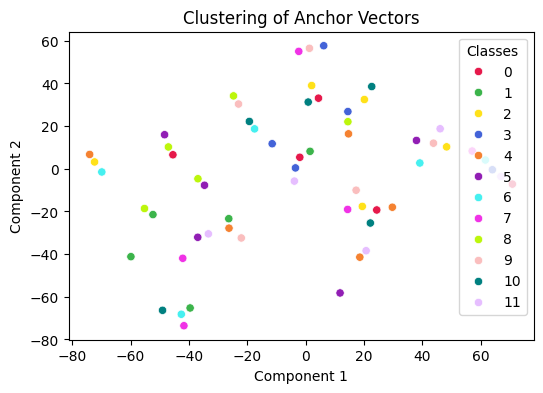

In [195]:
# Reduce dimensionality
#pca = PCA(n_components=2)
#reduced_vectors_before = pca.fit_transform(anchor_vectors_before)

# Alternatively, use t-SNE
tsne = TSNE(n_components=2,random_state=None,perplexity=3)
reduced_vectors_before = tsne.fit_transform(anchor_vectors_before)

#umap_reducer = umap.UMAP(n_components=2, random_state=42,n_neighbors=3)
#reduced_vectors_before = umap_reducer.fit_transform(anchor_vectors_before)

#
# Clustering
num_classes = 12
# Create a color palette with 13 distinct colors
palette = [
    "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4",
    "#46f0f0", "#f032e6", "#bcf60c", "#fabebe", "#008080", "#e6beff"
]
# Plotting
plt.figure(figsize=(6, 4))
sns.scatterplot(x=reduced_vectors_before[:, 0], y=reduced_vectors_before[:, 1], hue=labels,palette=palette, legend='full')
plt.title("Clustering of Anchor Vectors")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Classes", loc='upper right')
plt.show()


In [64]:
# Construct the artifact path
artifact_path = f"{user_or_team}/{project_name}/best_model_{new_run_name}:latest"
artifact=api.artifact(artifact_path)
artifact_dir=artifact.download()

if use_prototypes:
    prototypes_path = os.path.join(artifact_dir, f"prototypes_{new_run_name}.pth")

anchor_vectors_after_ = torch.load(prototypes_path, map_location=device)


prototype_norm = (
                anchor_vectors_after_.pow(2).sum(2, keepdim=True).pow(1.0 / 2.0)
            )  # normalize prototypes
anchor_vectors_after = anchor_vectors_after_.div(prototype_norm).reshape(-1,256).detach().numpy()

wandb: Downloading large artifact best_model_M2F-Swin-Tiny-CL-MeanLoss-Aug-Each_Prototypes_Lr1e-5:latest, 181.38MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:1.3


[ 4  7  6  2 11  5  3  6  9  3  1  0  2  4  4  7  6 10  6  8  4  3  0  6
  4  1 10 11  8  3  7  5  0  9  1  7  8  4  3  9  5  8 11  6 11  5  8  3
  4  1  4  5  2  2  5  1  3  7 10  4]
[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11]


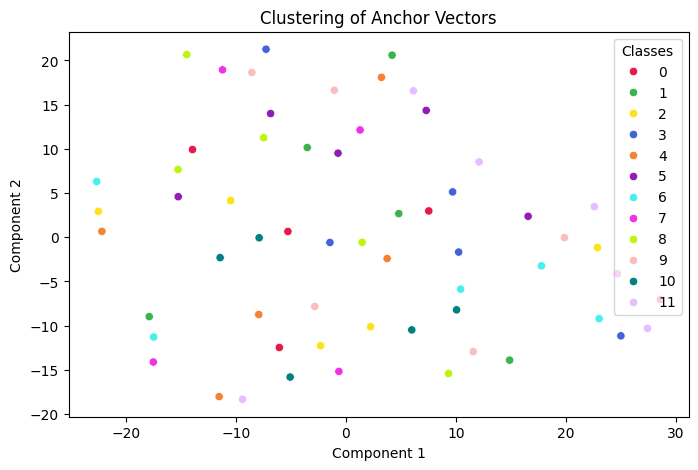

In [194]:
# Reduce dimensionality
#pca = PCA(n_components=2)
#reduced_vectors = pca.fit_transform(anchor_vectors)

# Alternatively, use t-SNE
tsne = TSNE(n_components=2,random_state=None,perplexity=10)
reduced_vectors_after = tsne.fit_transform(anchor_vectors_after)

kmeans = KMeans(n_clusters=num_classes, random_state=0)
clusters = kmeans.fit_predict(reduced_vectors_after)
print(clusters)
print(labels)


# Clustering
num_classes = 12
# Plotting
plt.figure(figsize=(8, 5))
sns.scatterplot(x=reduced_vectors_after[:, 0], y=reduced_vectors_after[:, 1], hue=labels, palette=palette,legend='full')
plt.title("Clustering of Anchor Vectors")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Classes", loc='upper right')
plt.show()
